# How I learnt to scrape Thailand’s COVID Data
## Dylan Jay
## ThaiPy 2021/03/11

# Why did I do this?


# What I learnt
- Getting files from web, webdav, json apis
    -  requests, webdavclient3
- Extracting from PDF, PDFS of PPTx, PowerPoint Charts and Excel
    - tabula, tika, BeautifulSoup4, xlrd, openpyxl, python-pptx, dateutil
- Combine and clean data
    - Pandas
- Plot the data
    - matplotlib/pandas
- Automate
    - github actions


# Why I did this


# Step 1: PDFs, how hard can it be?

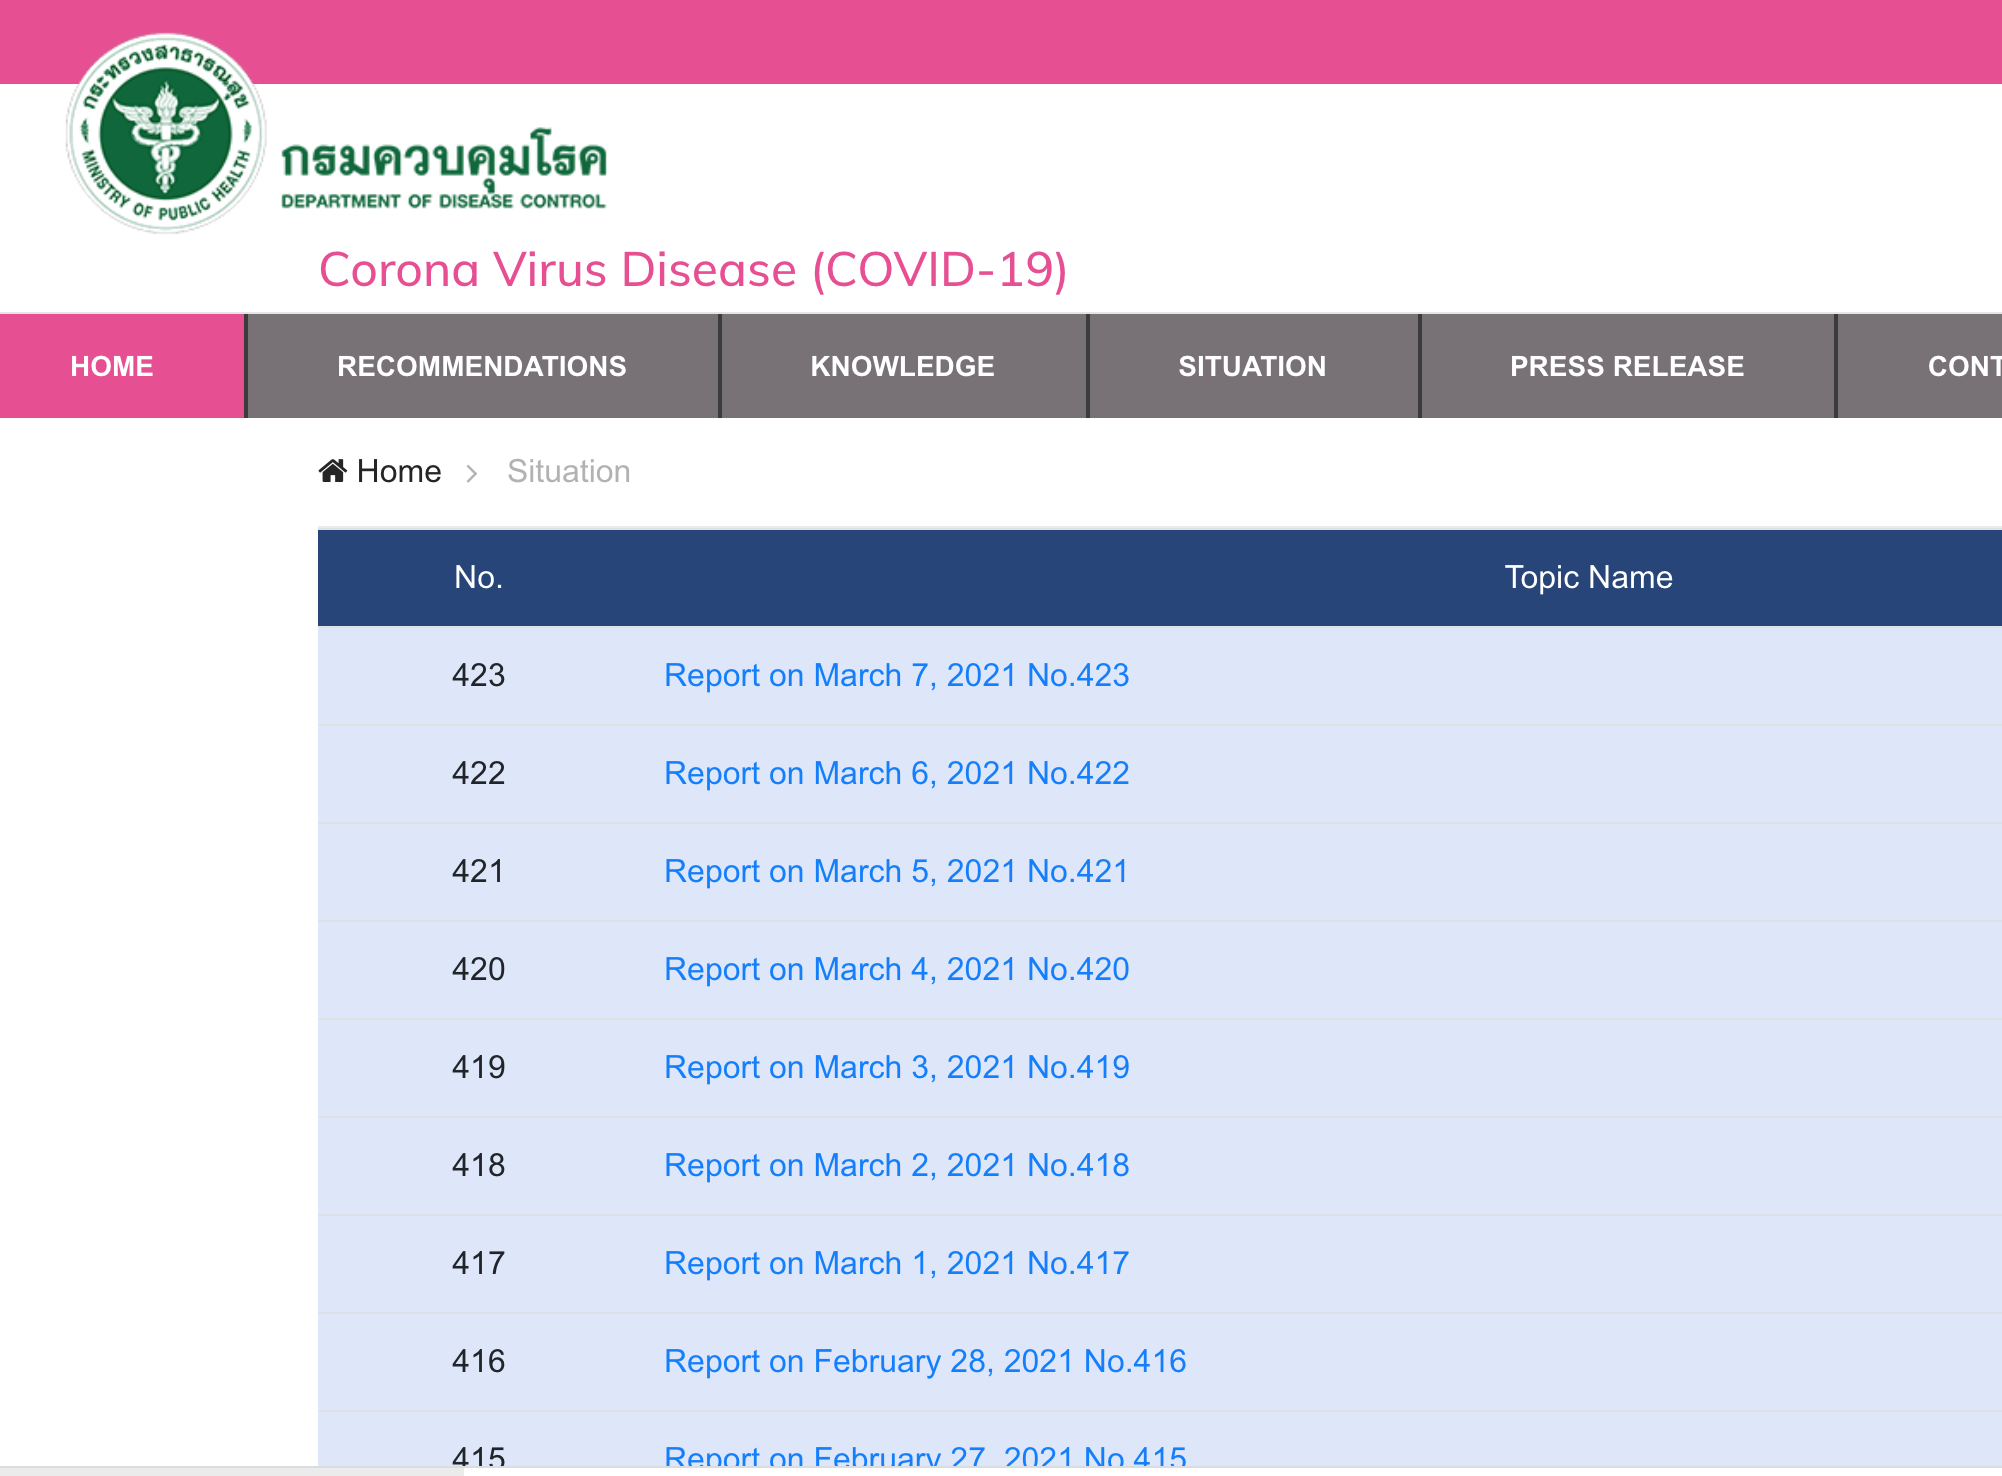

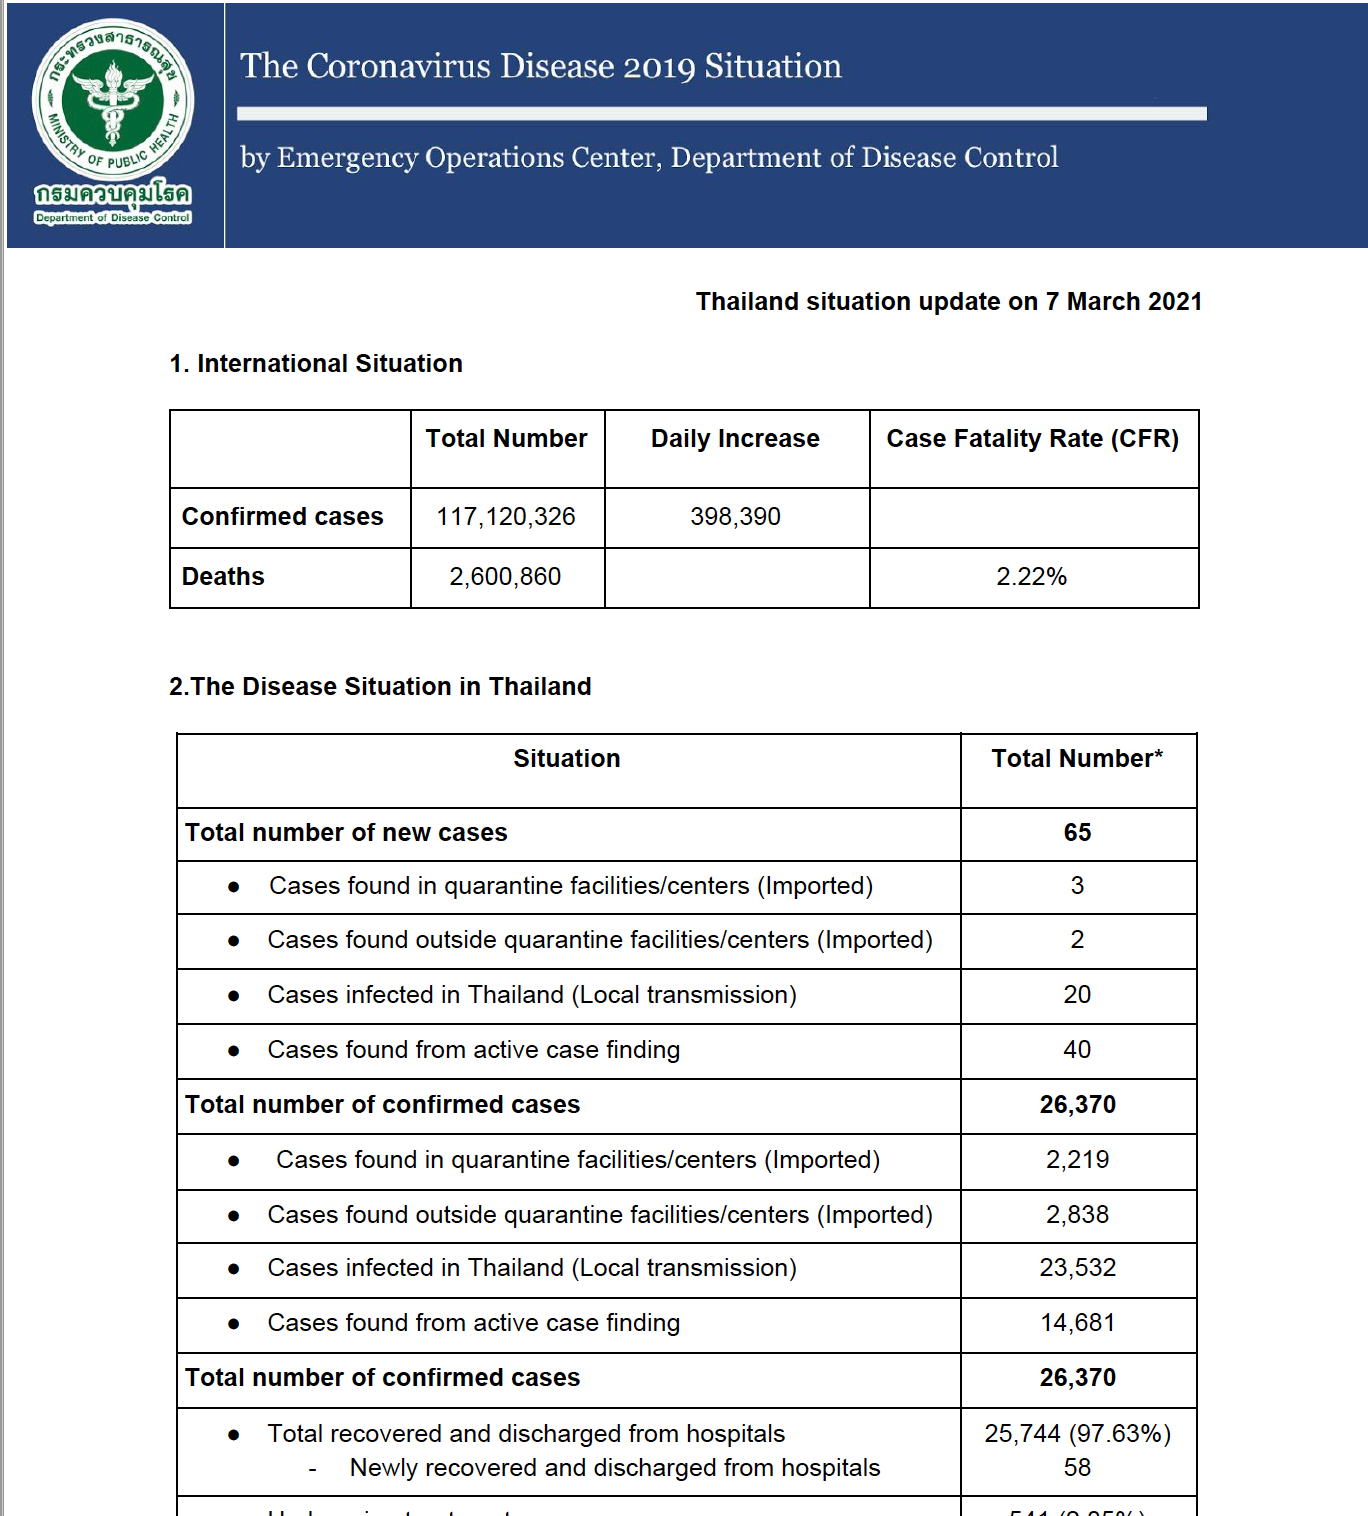



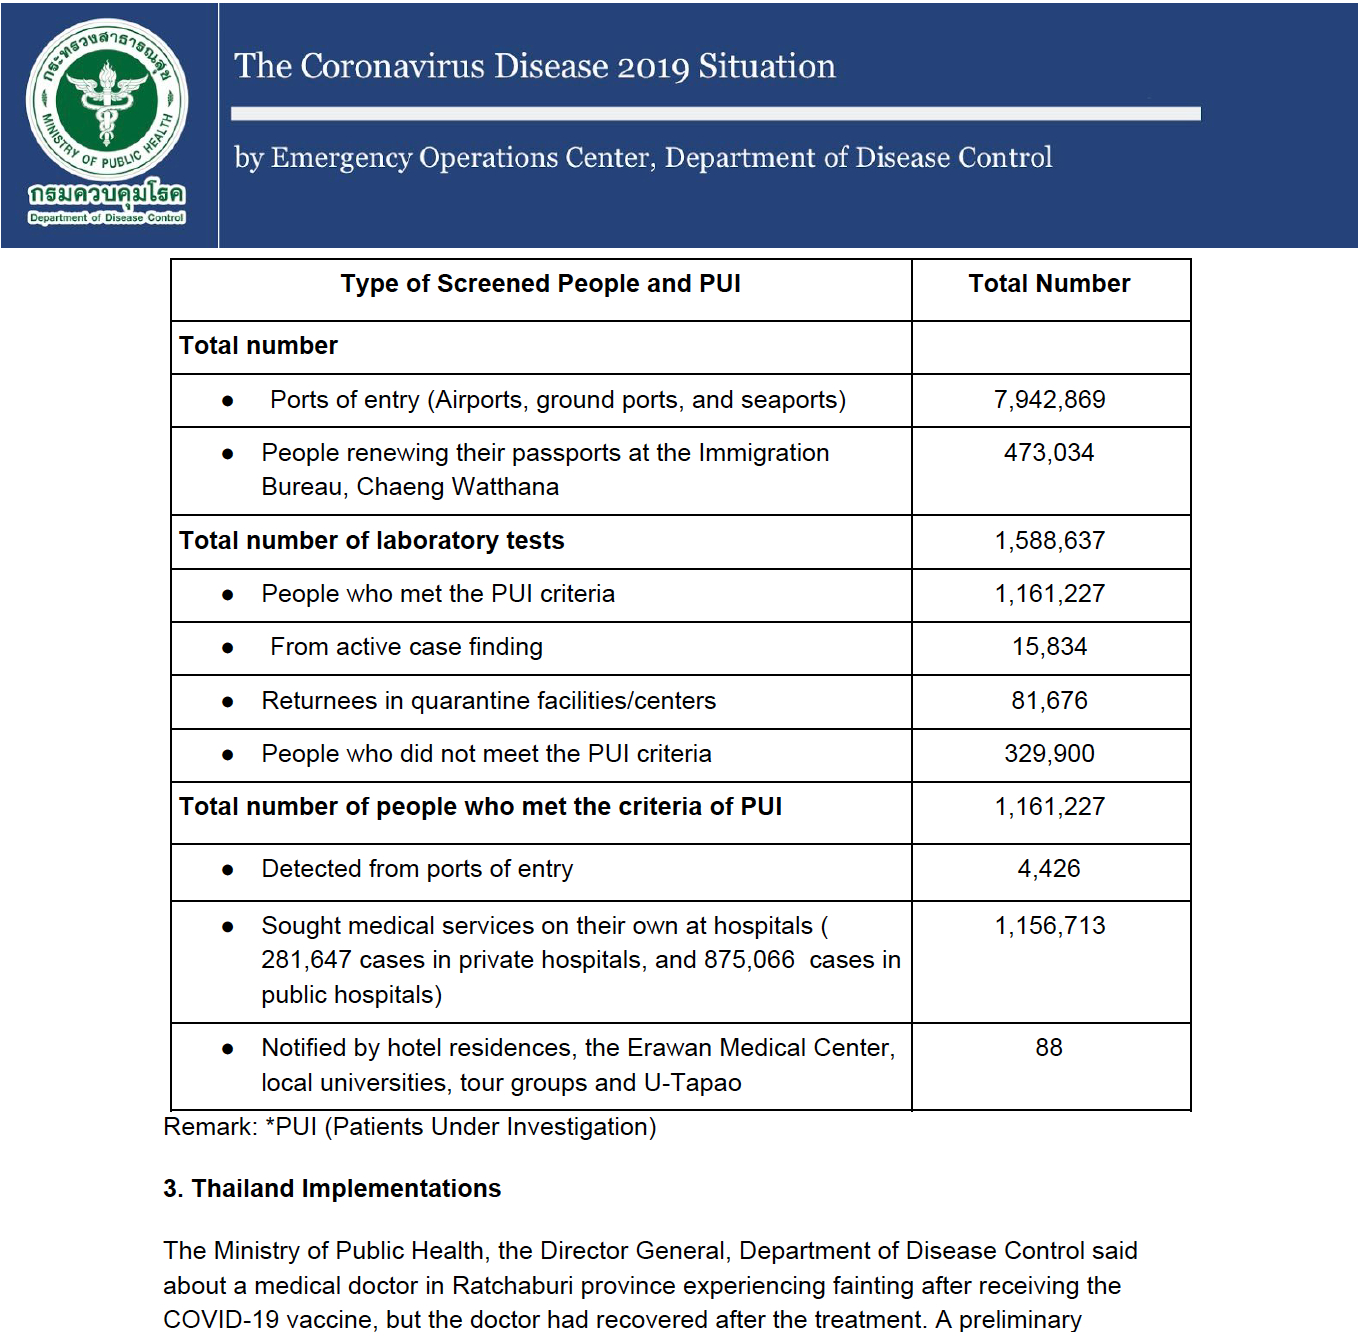

In [ ]:
import tabula
tabula.read_pdf("situation_en/situation-no423-070364.pdf", pages=1)

In [ ]:
tabula.read_pdf("situation_en/situation-no423-070364.pdf", pages=2)

# But...
- Didn't work for thai pdfs
- slow
- Not reliable - then you get nothing

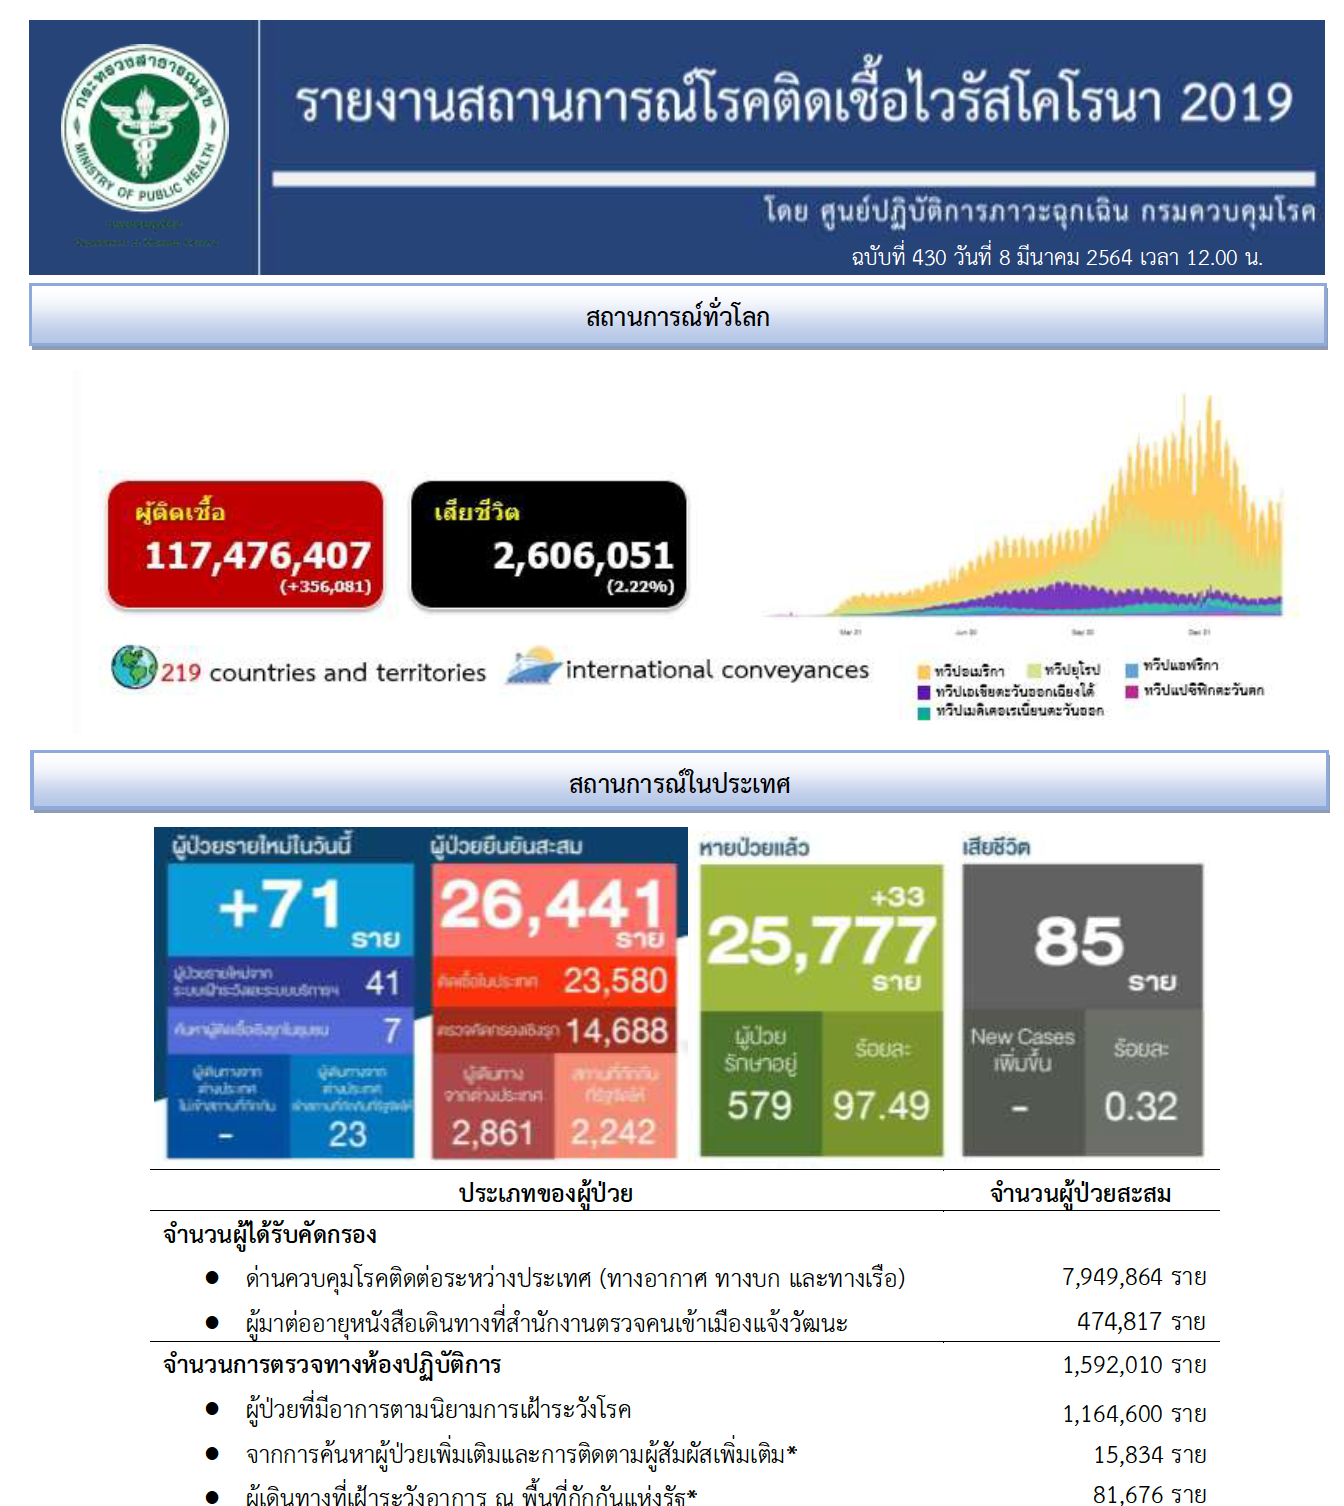

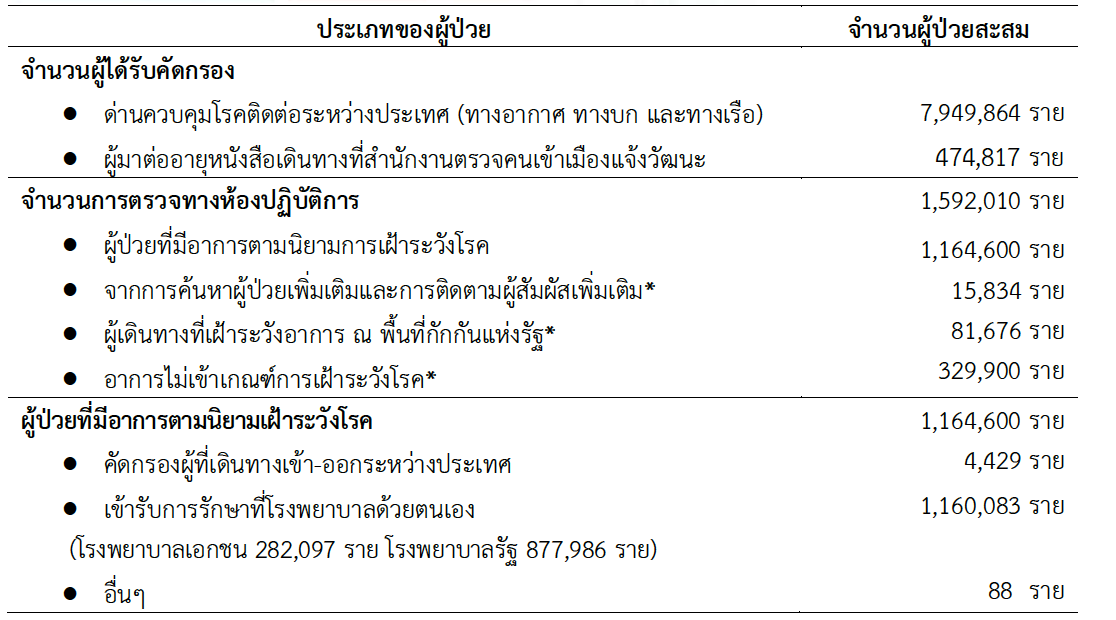

In [ ]:
tabula.read_pdf("situation_th/situation-no394-310164.pdf", pages=1)

# Tika
- fast
- gives text
- needs java
- does more than just pdfs

In [ ]:
from tika import parser
parsedPDF = parser.from_file("situation_en/situation-no423-070364.pdf")
print(parsedPDF['content'].strip())

In [ ]:
# Simple stupid number extraction

def get_next_numbers(content, *matches, debug=False):
    if len(matches) == 0:
        matches = [""]
    for match in matches:
        s = re.split(match, content) if match else ("", content)
        if len(s) >= 2:
            content = s[1]
            numbers = re.findall(r"[,0-9]+", content)
            numbers = [n.replace(",", "") for n in numbers]
            numbers = [int(n) for n in numbers if n]
            return numbers, match + " " + content
    if debug and matches:
        print("Couldn't find '{}'".format(match))
        print(content)
    return [], content


In [ ]:
numbers, content = get_next_numbers(parsedPDF['content'], "Total +number of laboratory tests",)
print(numbers)

# Downloading


In [ ]:
def web_links(*index_urls, ext=".pdf"):
    for index_url in index_urls:
        index = s.get(index_url)
        if index.status_code > 399: 
            continue
        links = re.findall("href=[\"'](.*?)[\"']", index.content.decode("utf-8"))
        for link in [urllib.parse.urljoin(index_url, l) for l in links if ext in l]:
            yield link

In [ ]:
from covidthailand import *
def web_files(*index_urls, ext=".pdf", dir=os.getcwd()):
    for url in web_links(*index_urls, ext):
        modified = s.head(url).headers.get("last-modified") if CHECK_NEWER else None
        file = url.rsplit("/", 1)[-1]
        file = os.path.join(dir, file)
        if is_remote_newer(file, modified):
            r = s.get(url)
            if r.status_code != 200:
                continue
            os.makedirs(os.path.dirname(file), exist_ok=True)
            with open(file, "wb") as f:
                for chunk in r.iter_content(chunk_size=512 * 1024):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
        if "pdf" in ext:
            content = parser.from_file(file)
        else:
            with open(file) as f:
                content = f.read()
        yield os.path.basename(file), content

In [ ]:
files = web_files("https://ddc.moph.go.th/viralpneumonia/eng/situation.php", ext=".pdf", dir="situation_en")
next(files)

# Putting it togeather

In [ ]:
def get_en_situation():
    results = []
    for file, parsedPDF in web_files(
        "https://ddc.moph.go.th/viralpneumonia/eng/situation.php", ext=".pdf", dir="situation_en"
    ):
        if "situation" not in file:
            continue
        date = file2date(file)
        numbers, _ = get_next_numbers(
            parsedPDF["content"], "Total +number of laboratory tests", debug=False
        )
        if numbers:
            tests_total, pui, active_finding, asq, not_pui, pui, pui_port, *rest = numbers
        else:
            numbers, _ = get_next_numbers(
                parsedPDF["content"], "Total number of people who met the criteria of patients", debug=False,
            )
            if date > dateutil.parser.parse("2020-01-30") and not numbers:
                raise Exception(f"Problem parsing {file}")
            elif not numbers:
                break
            tests_total, active_finding, asq, not_pui = [None] * 4
            pui, pui_airport, pui_seaport, pui_hospital, *rest = numbers
            pui_port = pui_airport + pui_seaport
        if pui in [1103858, 3891136, 433807, 96989]:  # mistypes?
            pui = None
        if tests_total in [783679, 849874, 936458]:
            tests_total = None
        results.append((date, tests_total, pui, active_finding, asq, not_pui))
        print(file, results[-1])

    results = pd.DataFrame(results,columns=["Date", "Tested", "PUI", "Active case finding", "ASQ", "Not PUI"]).set_index("Date")
    print(results)
    return results

In [ ]:
en_situation = get_en_situation()

In [ ]:
en_situation

# But...
- English reports are missing some files
- delayed for a few days

In [ ]:
th_situation = get_thai_situation()

In [ ]:
th_situation

# My first time with pandas
- Like a dict (when you add an index)
- or list of tupples
- Very intuitive
    - except combine_first - took time to discover this

In [ ]:
    situation = en_situation.combine_first(th_situation)
    situation = situation.interpolate()
    situation = situation - situation.shift(+1) # we got cumilitive data
    situation

# First time with matplotlib
- or at least it inside pandas

In [ ]:
%matplotlib inline
situation.plot()

# but...
- this data looks a bit weird

In [ ]:
situation['Not PUI'].plot()

# Total Test Performed
- isn't
- daily's same as PUI + some mid years
- Total People Tested?

In [ ]:
df['Tested (MA)'] = df['Tested'].rolling(7, 1, center=True).mean()
df['PUI (MA)'] = df['PUI'].rolling(7, 1, center=True).mean()
df[['Tested (MA)','PUI (MA)']].plot()

#  Positive Rate
- Positive Test Results / All Tests Results
- over %3 - Not testing enough
- under %3 - Maybe testing enough

# Cases
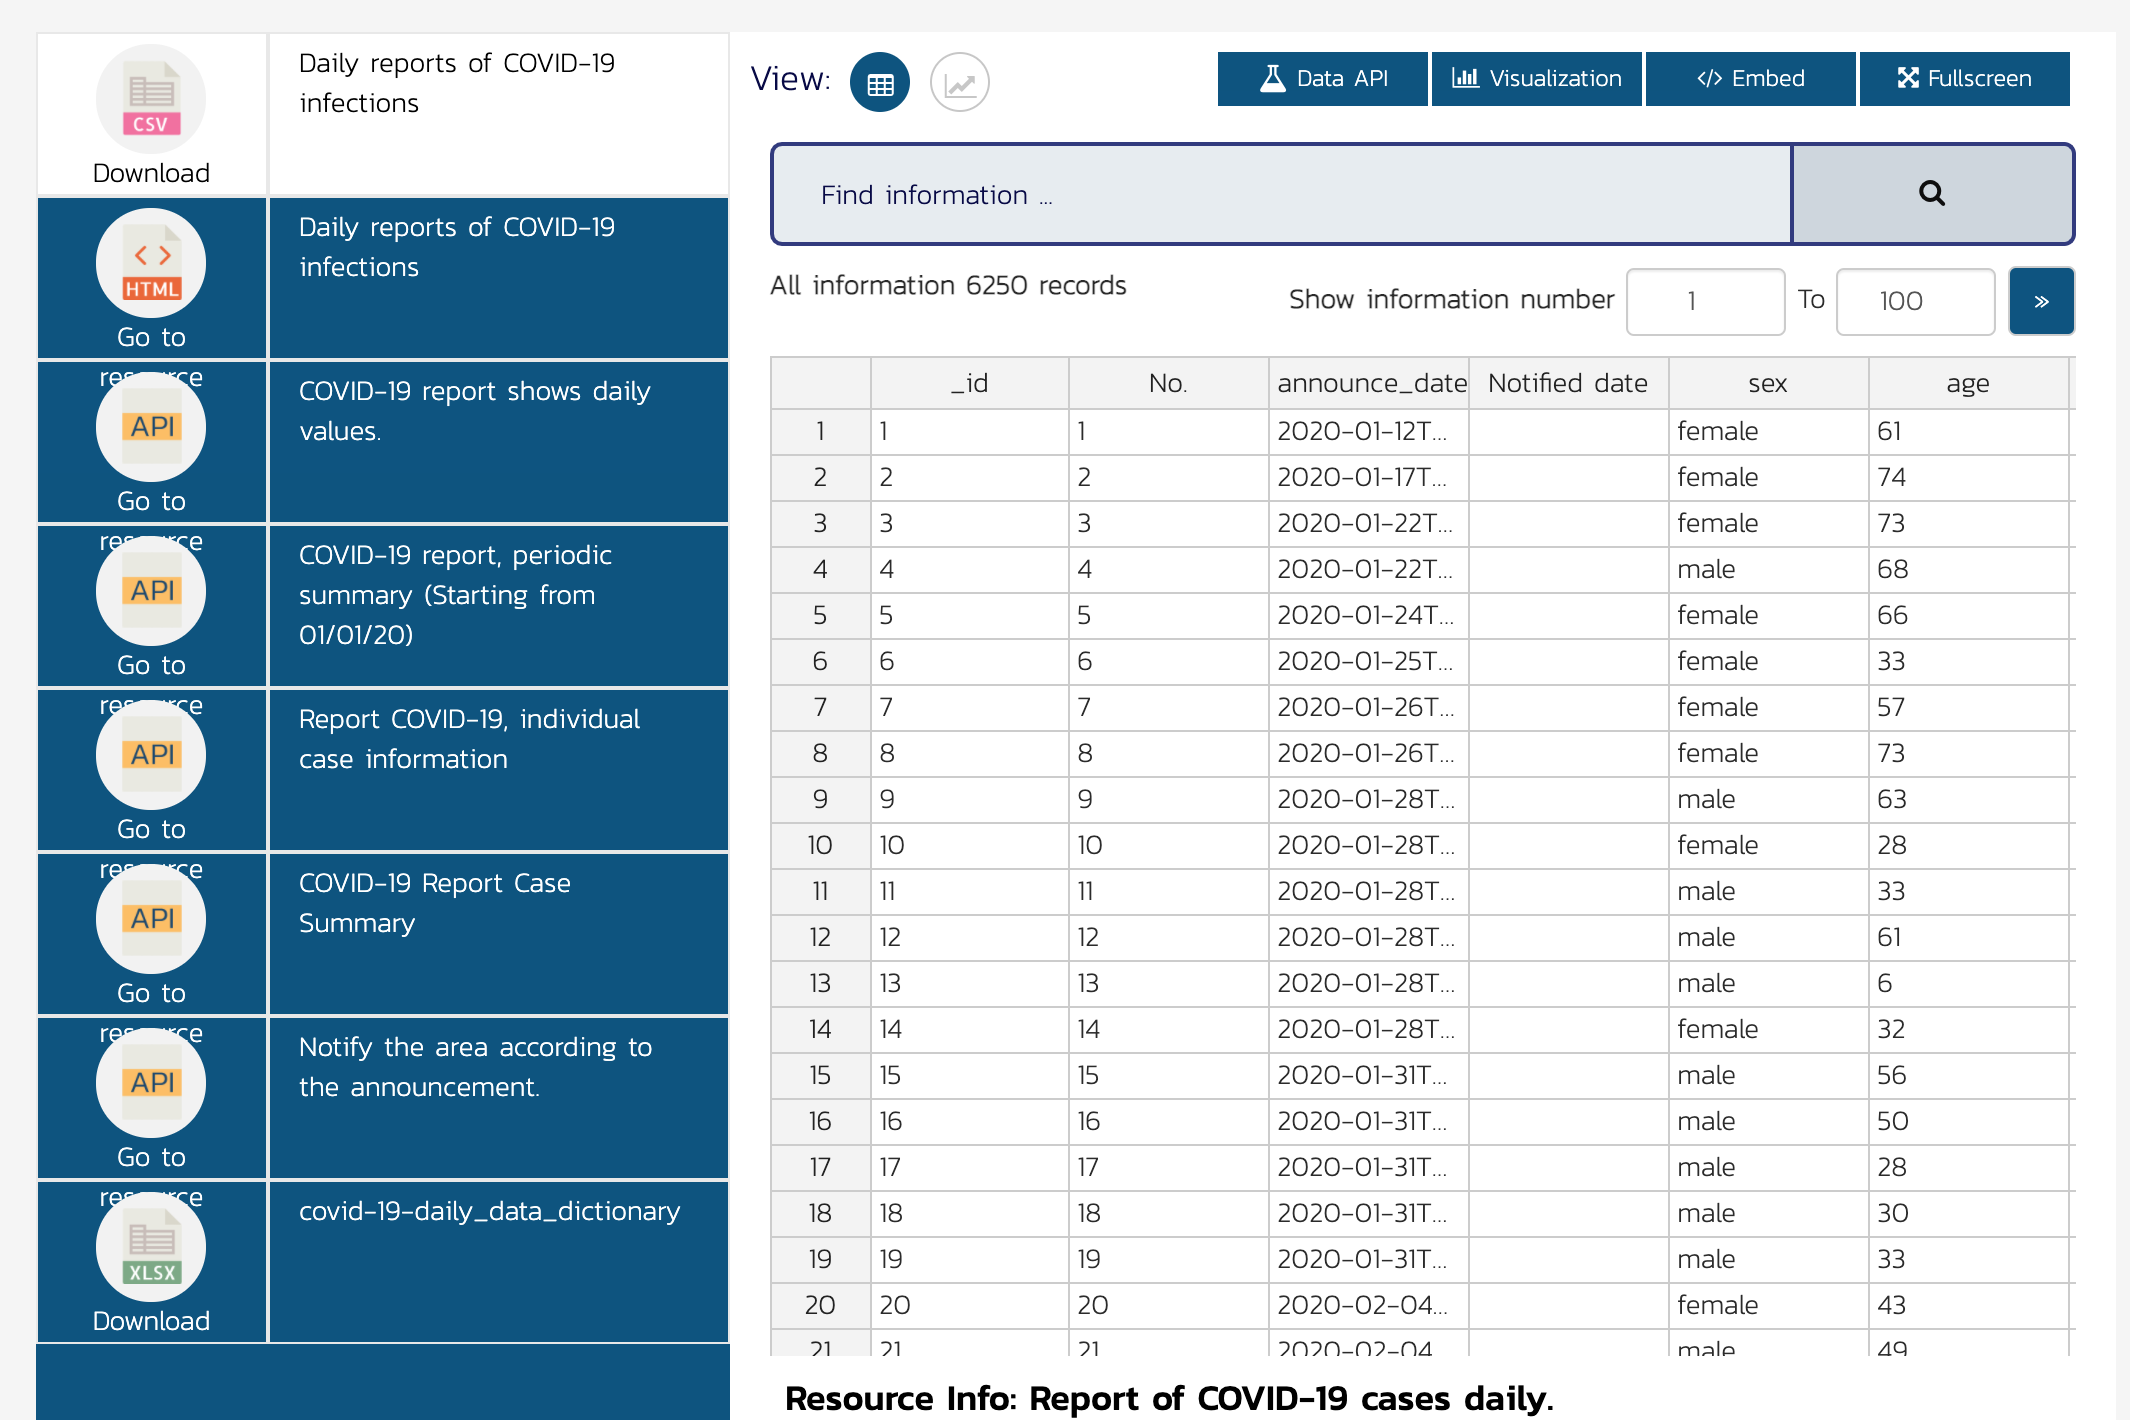

In [ ]:
def get_cases():
    timeline = s.get("https://covid19.th-stat.com/api/open/timeline").json()["Data"]
    results = []
    for d in timeline:
        date = datetime.datetime.strptime(d["Date"], "%m/%d/%Y")
        cases = d["NewConfirmed"]
        results.append((date, cases))
    data = pd.DataFrame(results, columns=["Date", "Cases"]).set_index("Date")
    return data

In [ ]:
cases = get_cases()
cases

In [ ]:
df = situation
df = df.combine_first(cases)
df

In [ ]:
df["Tested (MA)"] = df["Tested"].rolling(7, 1, center=True).mean()
df["PUI (MA)"] = df["PUI"].rolling(7, 1, center=True).mean()
df["Cases (MA)"] = df["Cases"].rolling(7, 1, center=True).mean()
df["Positivity PUI (MA)"] = df["Cases (MA)"] / df["PUI (MA)"] * 100
df.plot(y=["Positivity PUI (MA)"])

# but... 
- PUI isn't tests
- not including
    - Private tests
    - "Active testing"
    - ?
- but is it an upper bound?

# The tests came back...
- https://service.dmsc.moph.go.th/labscovid19/indexen.php
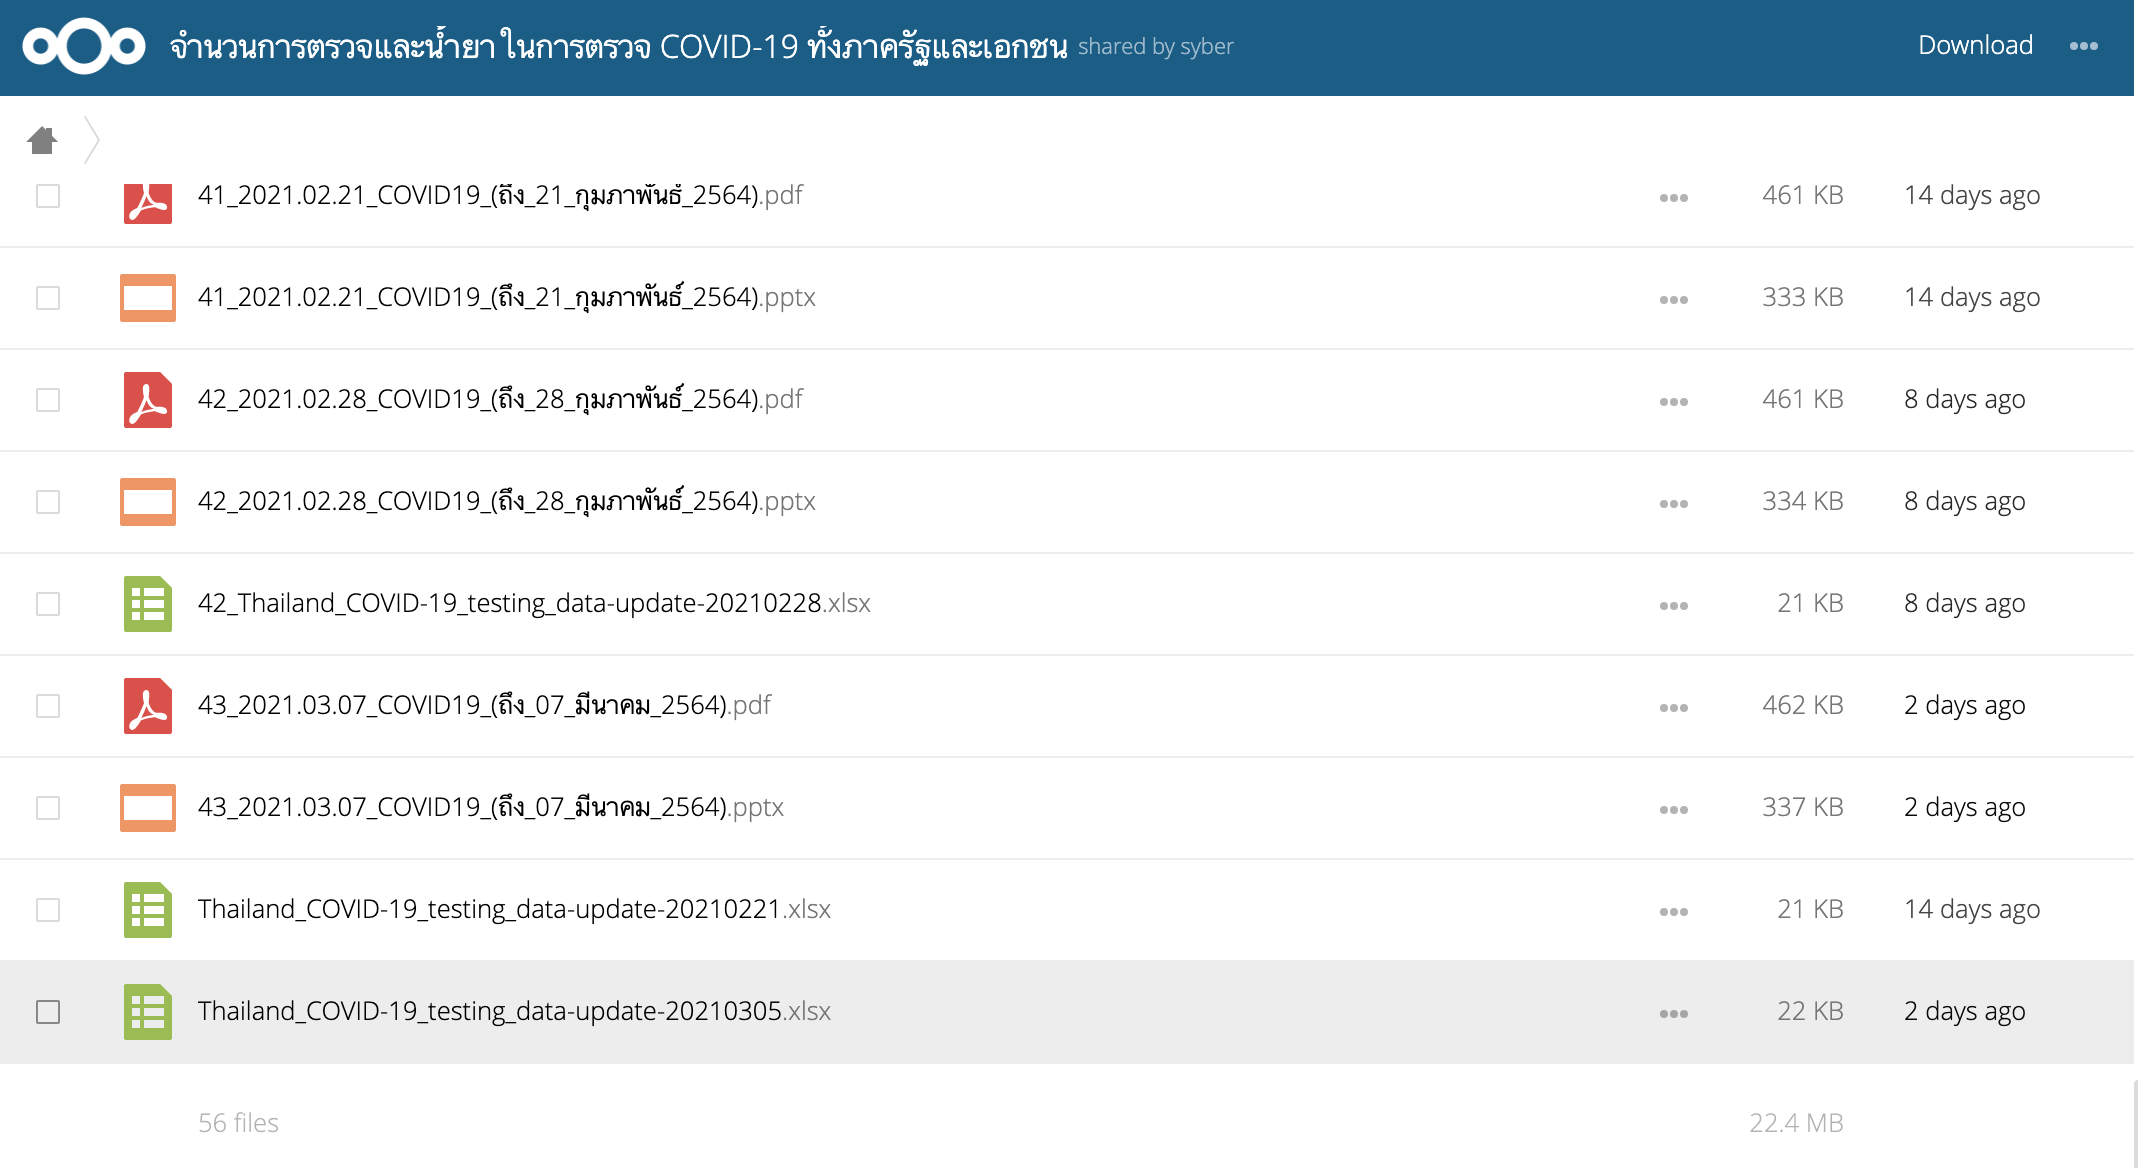

# but...
- It's JS not HTML
- It's WebDAV

In [ ]:
from webdav3.client import Client
options = {
    "webdav_hostname": "http://nextcloud.dmsc.moph.go.th/public.php/webdav",
    "webdav_login": "wbioWZAQfManokc",
    "webdav_password": "null",
}
client = Client(options)
client.list()

In [ ]:
client.download_file("Thailand_COVID-19_testing_data-update-20210305.xlsx", 
                     "testing_moph/Thailand_COVID-19_testing_data-update-20210305.xlsx"
                    )
pd.read_excel("testing_moph/Thailand_COVID-19_testing_data-update-20210305.xlsx", parse_dates=True, usecols=[0, 1, 2])

# but...
- What's this "Cannot specify date"?
- 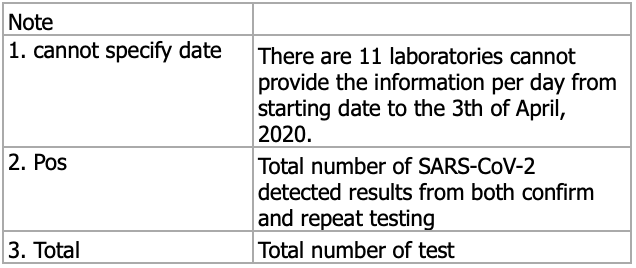

In [ ]:
tests = pd.read_excel("testing_moph/Thailand_COVID-19_testing_data-update-20210305.xlsx", parse_dates=True, usecols=[0, 1, 2])

tests.dropna(how="any", inplace=True)  # get rid of totals row
tests = tests.set_index("Date")
pos = tests.loc["Cannot specify date"].Pos
total = tests.loc["Cannot specify date"].Total
tests.drop("Cannot specify date", inplace=True)
# Need to redistribute the unknown values across known values
# Documentation tells us it was 11 labs and only before 3 April
# TODO: still doesn't redistribute all missing values due to rounding. about 200 left
unknown_end_date = datetime.datetime(day=3, month=4, year=2020)
all_pos = tests["Pos"][:unknown_end_date].sum()
all_total = tests["Total"][:unknown_end_date].sum()
for index, row in tests.iterrows():
    if index > unknown_end_date:
        continue
    row.Pos = float(row.Pos) + row.Pos / all_pos * pos
    row.Total = float(row.Total) + row.Total / all_total * total
# fix datetime
tests.reset_index(drop=False, inplace=True)
tests["Date"] = pd.to_datetime(tests["Date"])
tests.set_index("Date", inplace=True)
tests.rename(columns=dict(Pos="Pos XLS", Total="Tests XLS"), inplace=True)
tests.plot()


# but...
- doesn't seem to match our PUI and Cases data

In [ ]:
df = df.combine_first(tests)
df["Tests XLS (MA)"] = df["Tests XLS"].rolling(7, 1, center=True).mean()
df["Pos XLS (MA)"] = df["Pos XLS"].rolling(7, 1, center=True).mean()
df.plot(y=["Tests XLS (MA)", "PUI (MA)"])

In [ ]:
df.plot(y=["Pos XLS (MA)", "Cases (MA)"])

# Missing Tests
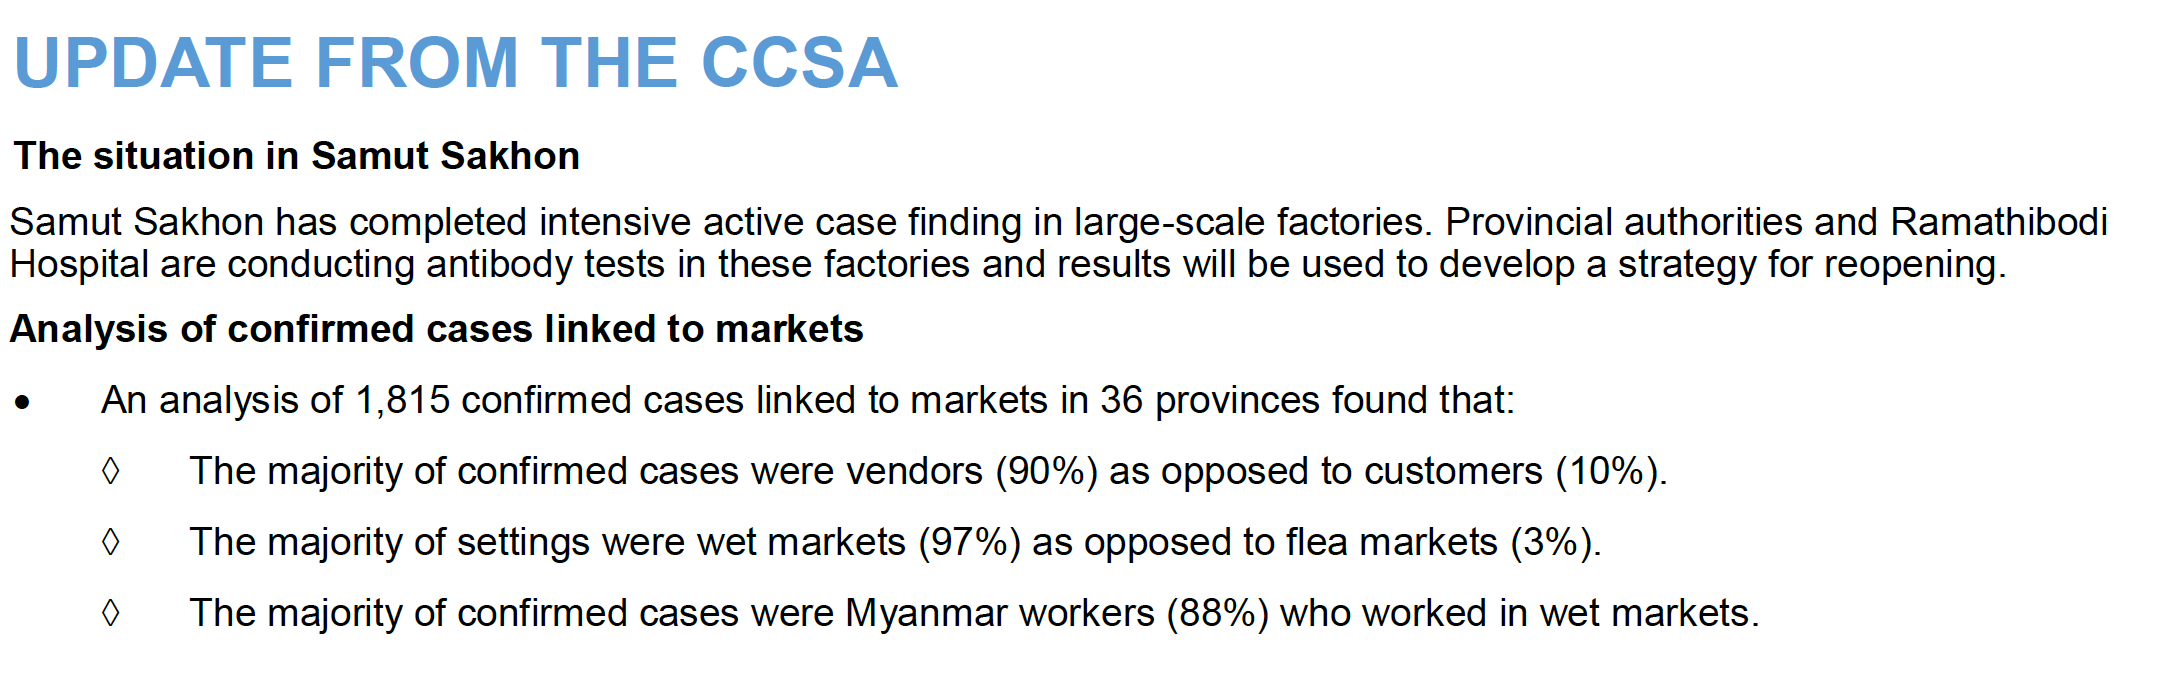


In [ ]:
df["Positivity XLS (MA)"] = df["Pos XLS (MA)"] / df["Tests XLS (MA)"] * 100
df.plot(y=["Positivity XLS (MA)","Positivity PUI (MA)"])

# but...
- Are there other tests missing?

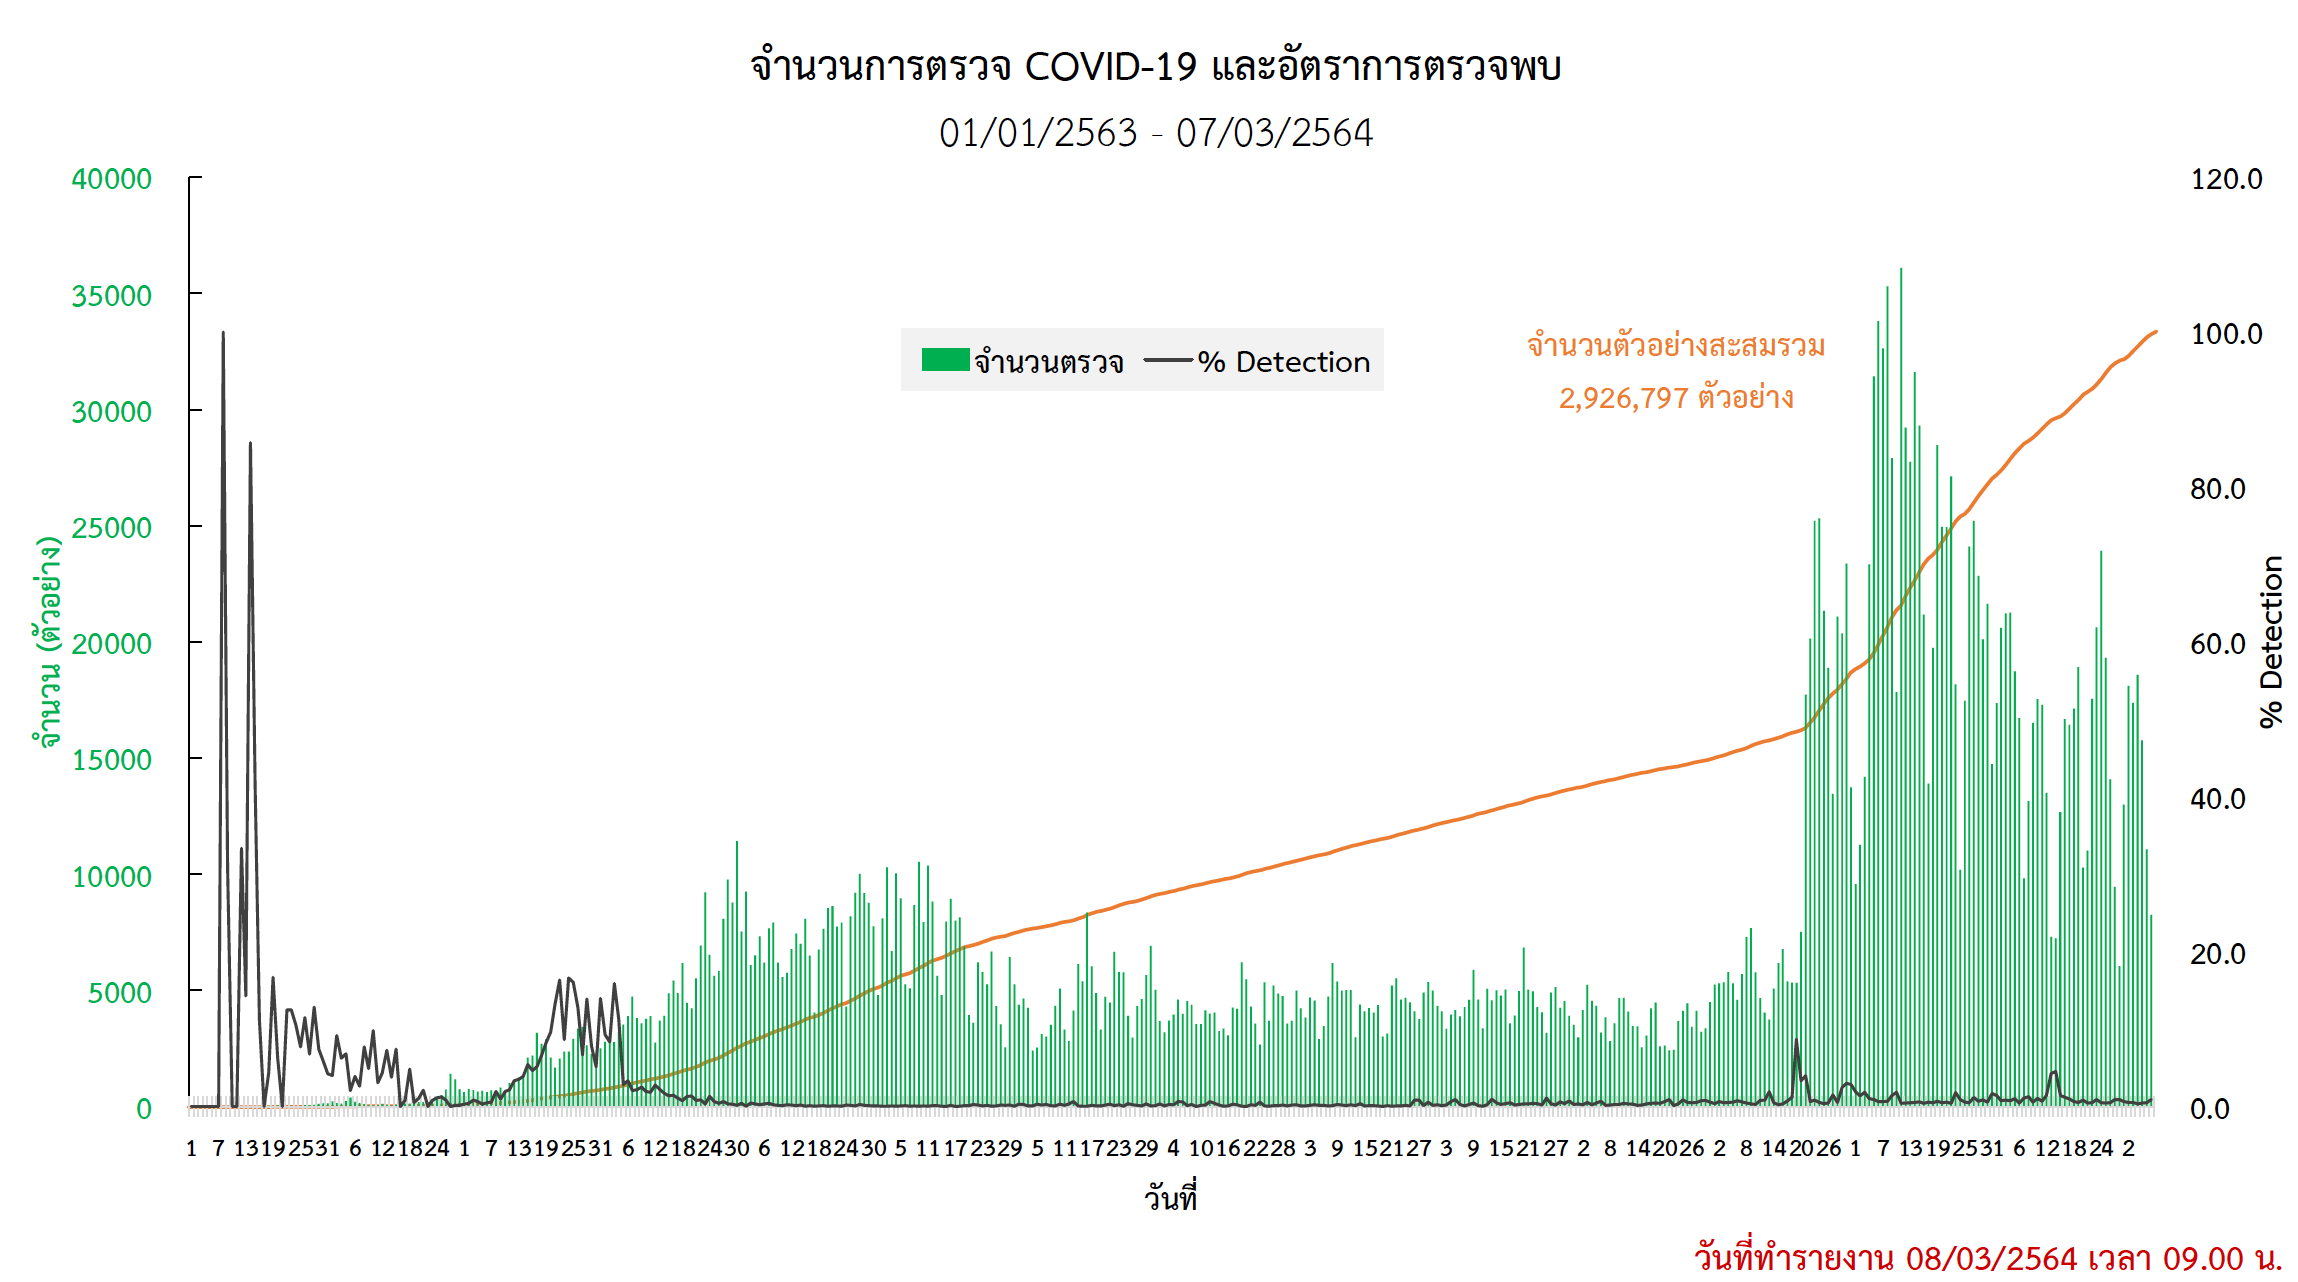

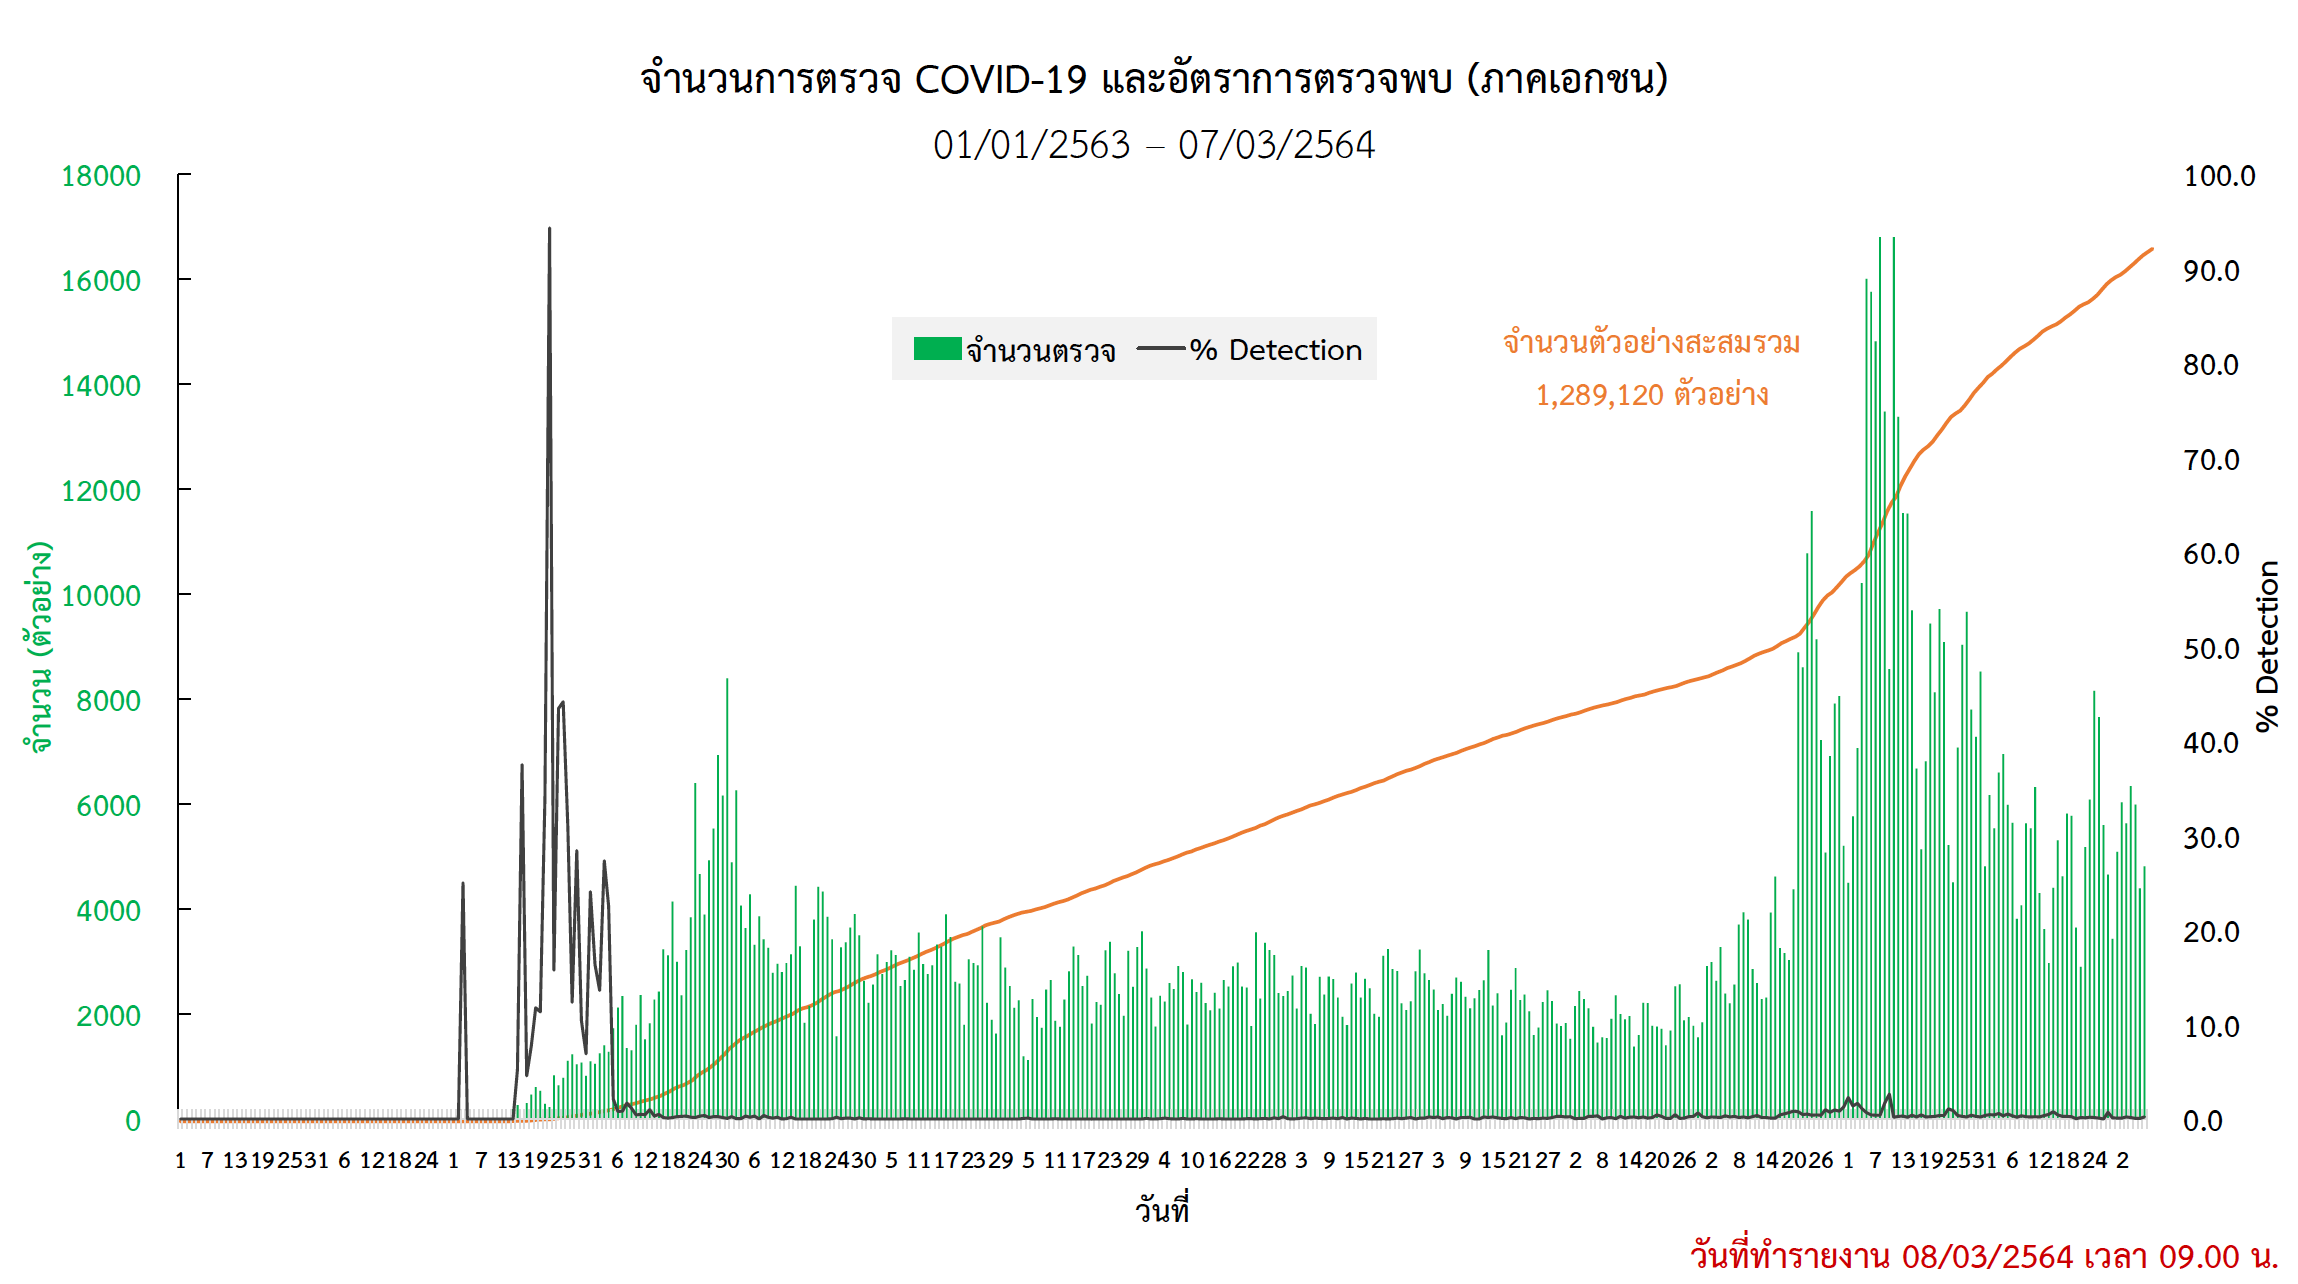

In [ ]:
from pptx import Presentation
file = next(dav_files(
        "http://nextcloud.dmsc.moph.go.th/public.php/webdav",
        "wbioWZAQfManokc",
        "null",
        ext=".pptx",
        dir="testing_moph",
    ))
prs = Presentation(file)
list(chart for slide in prs.slides for chart in slide2chartdata(slide))

In [ ]:
def slide2chartdata(slide):
    for shape in slide.shapes:
        if not shape.has_chart:
            continue
        chart = shape.chart
        if chart is None:
            continue
        title = chart.chart_title.text_frame.text if chart.has_title else ""
        start, end = find_date_range(title)
        if start is None:
            continue
        series = dict([(s.name, s.values) for s in chart.series])

        yield chart, title, start, end, series

In [ ]:
tests_priv = get_tests_private_public()
tests_priv

In [ ]:
df = df.combine_first(tests_priv)
df["Tests Public (MA)"] = df["Tests Public"].rolling(7, 1, center=True).mean()
df["Tests Private (MA)"] = df["Tests Private"].rolling(7, 1, center=True).mean()
df.plot(y=["Tests XLS (MA)","Tests Public (MA)", "Tests Private (MA)"])

In [ ]:
df["Pos Public (MA)"] = df["Pos Public"].rolling(7, 1, center=True).mean()
df["Pos Private (MA)"] = df["Pos Private"].rolling(7, 1, center=True).mean()
df.plot(y=["Pos XLS (MA)","Pos Public (MA)", "Pos Private (MA)"])

# Should positive rate include private tests?

In [ ]:
df["Pos Public (MA)"] = df["Pos Public"].rolling(7, 1, center=True).mean()
df["Pos Private (MA)"] = df["Pos Private"].rolling(7, 1, center=True).mean()
df["Tests Public (MA)"] = df["Tests Public"].rolling(7, 1, center=True).mean()
df["Tests Private (MA)"] = df["Tests Private"].rolling(7, 1, center=True).mean()

df["Pos Corrected+Private (MA)"] = df["Pos Private (MA)"] + df["Pos XLS (MA)"]
df["Tests Private+Public (MA)"] = df["Tests Public (MA)"] + df["Tests Private (MA)"]
df["Tests Corrected+Private (MA)"] = df["Tests XLS (MA)"] + df["Tests Private (MA)"]


df["Positivity Private (MA)"] = (
    df["Pos Private (MA)"] / df["Tests Private (MA)"] * 100
)
df["Positivity Public+Private (MA)"] = (
    df["Pos Corrected+Private (MA)"] / df["Tests Corrected+Private (MA)"] * 100
)

df.plot(y=["Positivity Public+Private (MA)","Positivity XLS (MA)","Positivity Private (MA)"])

# Problems with Positive Rate
- Assumes infected are equally likely to be tested
- Migrants without health insurance or visa
- Work pressure
- Does it matter where you live?
   - "Are they just testing Migrants in Factories?"

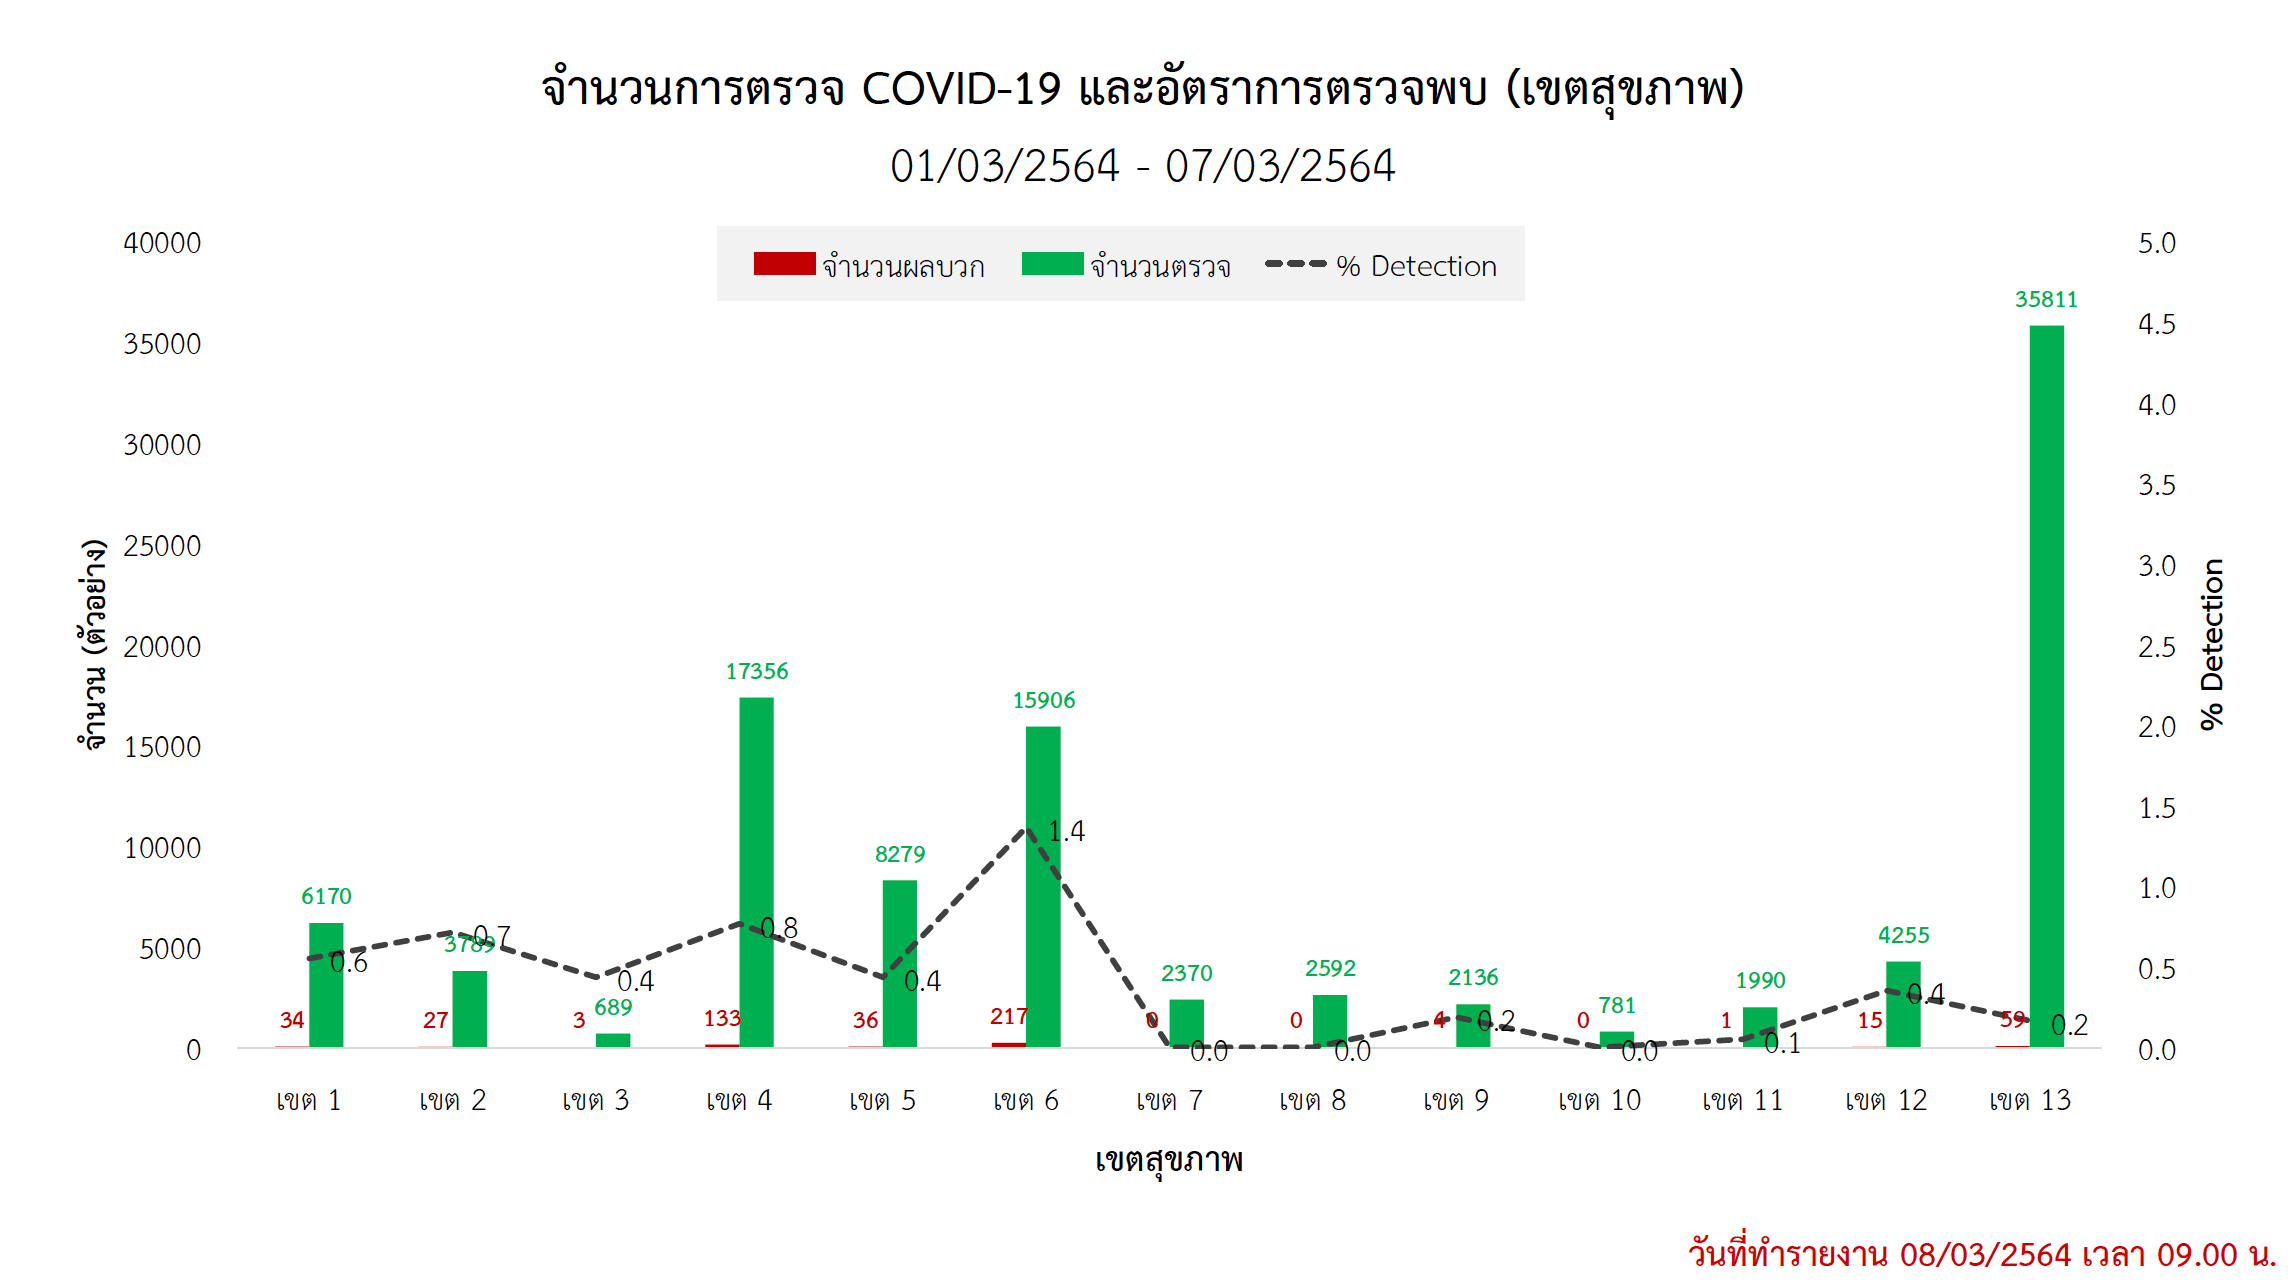

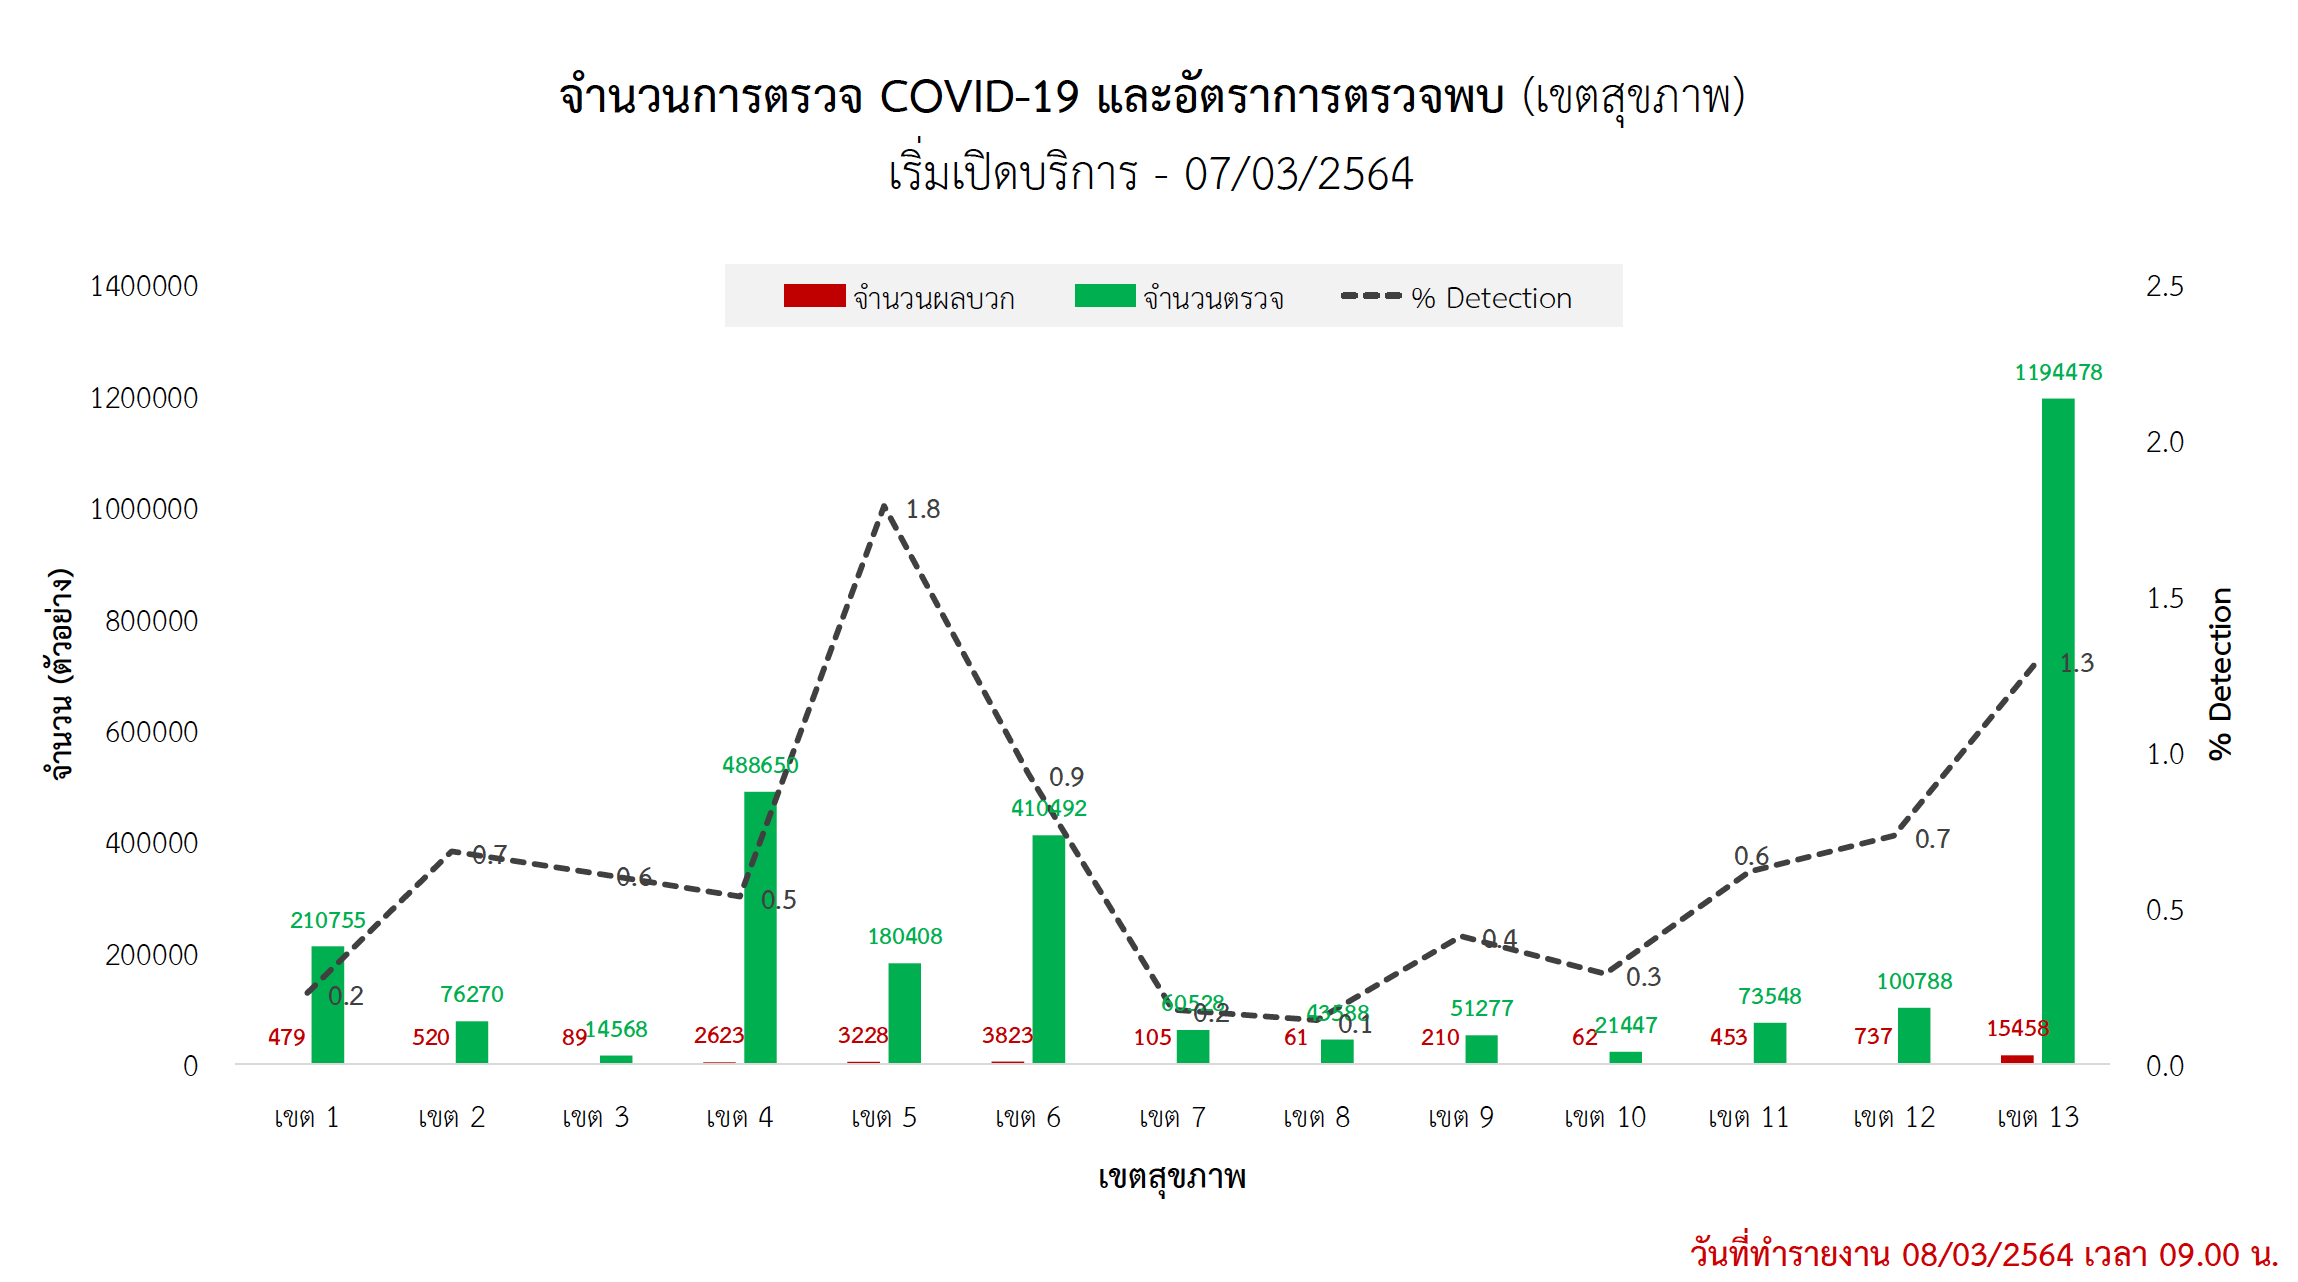

In [ ]:
POS_AREA_COLS = ["Pos Area {}".format(i + 1) for i in range(13)]
TESTS_AREA_COLS = ["Tests Area {}".format(i + 1) for i in range(13)]
columns = ["Date"] + POS_AREA_COLS + TESTS_AREA_COLS + ["Pos Area", "Tests Area"]
data = pd.DataFrame()

# Need both pptx and pdf as one pdf is missing
for file in dav_files(ext=".pptx"):
    for slide in Presentation(file).slides:
        for chart, title, start, end, series in slide2chartdata(slide):
            if "เริ่มเปิดบริการ" in title:
                continue
            if none(t in title for t in ["เขตสุขภาพ", "เขตสุขภำพ"]):
                continue
            # the graph for X period split by health area.
            pos = list(series["จำนวนผลบวก"])
            tests = list(series["จำนวนตรวจ"])
            row = pos + tests + [sum(pos), sum(tests)]
            results = spread_date_range(start, end, row, columns)
            print(results)
            data = data.combine_first(results)

In [ ]:
data.plot(y=POS_AREA_COLS)

In [ ]:
data.plot(y=TEST_AREA_COLS)

In [ ]:
for area in range(1, 14):
    df[f"Positivity {area}"] = (
        df[f"Pos Area {area}"] / df[f"Tests Area {area}"] * 100
    )
cols = [f"Positivity {area}" for area in range(1, 14)]
df["Total Positivity Area"] = df[cols].sum(axis=1)
# Scale so whole bar is public positivity
for area in range(1, 14):
    df[f"Positivity {area}"] = (
        df[f"Positivity {area}"]
        / df["Total Positivity Area"]
        * df["Positivity XLS (MA)"]
    )

df.plot(y=cols, kind="area")